# Hourly Energy Consumption.
![energy](energy.jpg)

# Giới thiệu project

Chủ đề: Hourly Energy Consumption.

Mục tiêu: 
- Phân tích xu hướng tiêu thụ điện theo thời gian và khu vực.
- Xây dựng mô hình dự báo tiêu thụ điện năng.
- Trình bày kết quả bằng đồ thị và báo cáo chi tiết.

---

## Import thư viện



- Xử lý và phân tích dữ liệu: `pandas`, `numpy`
- Vẽ biểu đồ: `matplotlib`, `seaborn`
- Dự báo và học máy: `xgboost`, `RandomForestRegressor`
- Đánh giá mô hình: `mean_absolute_error`, `mean_squared_error`, `r2_score`
- Phân tích chuỗi thời gian: `plot_acf`, `adfuller`
- Tiền xử lý và quy trình huấn luyện mô hình: `Pipeline`, `FunctionTransformer`


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

---
# 1. Thu thập dữ liệu

Bài tập cung cấp nhiều tệp .csv tương ứng với dữ liệu tiêu thụ điện năng theo từng vùng (region) thuộc hệ thống lưới điện PJM. Mỗi file đại diện cho một khu vực như `AEP`, `COMED`, `DAYTON`,… và chứa thông tin tiêu thụ điện năng theo giờ. Trong đó, pjm_hourly_est.csv là file chứa các cột tương ứng với từng region, cùng một cột thời gian chung nên ta sẽ quan sát dữ liệu ở đây trước.

In [65]:
pjm_data = pd.read_csv('data/pjm_hourly_est.csv')
pjm_data['Datetime'] = pd.to_datetime(pjm_data['Datetime'])
pjm_data = pjm_data.set_index('Datetime')

In [66]:
pjm_data.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


Kiểm tra giá trị bị thiếu(NaN) trong từng cột thể hiện điện năng tiêu thụ của mỗi vùng

In [67]:
missing_values = pjm_data.isnull().sum()
print("Giá trị thiếu trong mỗi cột:\n", missing_values)
missing_percentage = (missing_values / len(pjm_data)) * 100
print("\nPhần trăm giá trị thiếu trong mỗi cột:")
for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}%")

Giá trị thiếu trong mỗi cột:
 AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

Phần trăm giá trị thiếu trong mỗi cột:
AEP: 31.97%
COMED: 62.70%
DAYTON: 31.97%
DEOK: 67.61%
DOM: 34.82%
DUQ: 33.21%
EKPC: 74.57%
FE: 64.73%
NI: 67.21%
PJME: 18.45%
PJMW: 19.67%
PJM_Load: 81.55%


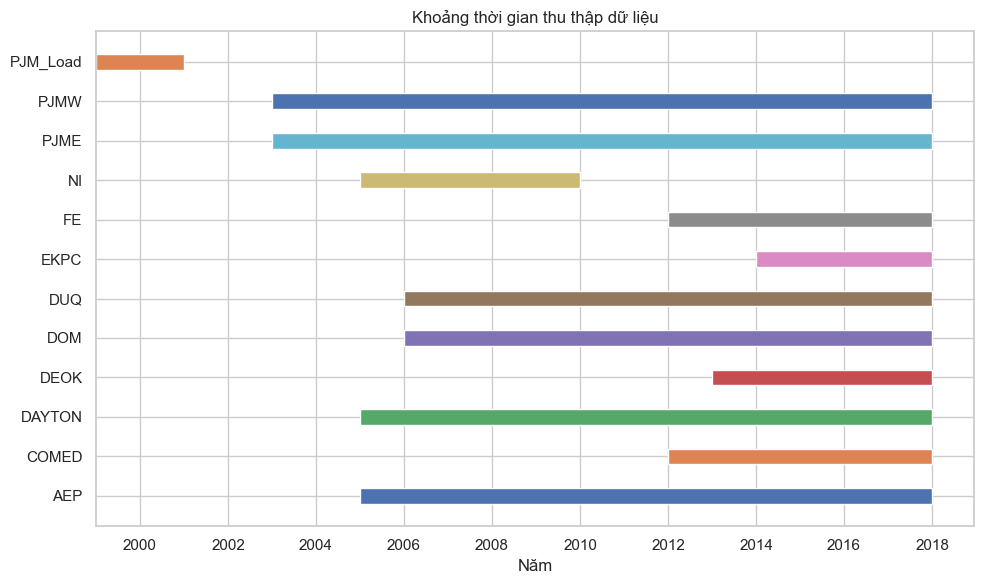

In [68]:
# Giả sử df là DataFrame của bạn, cột 'datetime' là cột thời gian
pjm_data.index = pd.to_datetime(pjm_data.index)

# Tạo danh sách thời gian bắt đầu và kết thúc cho từng khu vực
start_end_times = []

for col in pjm_data.columns:
    start = pjm_data[col].first_valid_index()
    end = pjm_data[col].last_valid_index()
    if start and end:
        start_end_times.append((col, start, end))

# Vẽ biểu đồ thanh ngang
fig, ax = plt.subplots(figsize=(10, len(start_end_times) * 0.5))

for i, (col, start, end) in enumerate(start_end_times):
    ax.barh(y=col, width=end - start, left=start, height=0.4)

ax.set_xlabel('Năm')
ax.set_title('Khoảng thời gian thu thập dữ liệu')
plt.tight_layout()
plt.show()

Sau khi kiểm tra giá trị thiếu, tôi nhận thấy nhiều vùng có tỷ lệ thiếu >60%, gây khó khăn cho việc khai thác insight và xây dựng mô hình chính xác. Vì vậy, tôi quyết định phân tích từng vùng riêng biệt thay vì dùng dữ liệu tổng hợp. 
Tôi bắt đầu với vùng `PJME` vì vùng này có tỷ lệ thiếu thấp (~18%) và dữ liệu ổn định hơn.

---
# 2. Khám phá dữ liệu

In [69]:
PJME_df_origin = pd.read_csv('PJME_hourly.csv', encoding='utf-8-sig')

PJME_df = PJME_df_origin.copy()
PJME_df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


### Kích thước và kiểu dữ liệu của các cột

In [70]:
# Các cột hiện có kiểu dữ liệu gì?
PJME_df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [71]:
PJME_df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Chuyển kiểu dữ liệu của cột `Datetime` từ dạng `object` (chuỗi) sang kiểu `datetime` để hỗ trợ xử lý dữ liệu thời gian như phân tích theo ngày, giờ, hoặc tạo chỉ mục thời gian.


In [72]:
# Xử lý cột có thể bị lỗi tên
PJME_df.columns = PJME_df.columns.str.strip()  # Xóa khoảng trắng

# In thử tên cột để chắc chắn
print(PJME_df.columns.tolist())

PJME_df['Datetime'] = pd.to_datetime(PJME_df['Datetime'])
PJME_df = PJME_df.set_index('Datetime')

['Datetime', 'PJME_MW']


### Kiểm tra dữ liệu bị trùng

In [73]:
print("Check of Duplicates (Datetime):")
duplicate = PJME_df[PJME_df.index.duplicated(keep=False)]
duplicate

Check of Duplicates (Datetime):


,PJME_MW
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


### Kiểm tra dữ liệu bị thiếu

In [74]:
start = PJME_df.index.min()
end = PJME_df.index.max()

full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

missing_dates = full_range.difference(PJME_df.index)

print(f"Số lượng thời điểm bị thiếu: {len(missing_dates)}")
missing_dates

Số lượng thời điểm bị thiếu: 30


DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

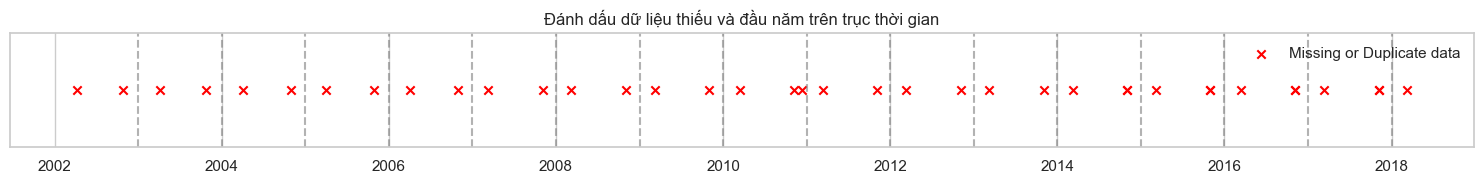

In [75]:
plt.figure(figsize=(15, 2))

mark = pd.concat([
    pd.Series(missing_dates),
    pd.Series(duplicate.index)
])

# Vẽ các điểm x cho missing
plt.scatter(mark, [0]*len(mark), marker='x', color='red', label='Missing or Duplicate data')

# Vẽ vạch dọc tại mỗi mốc đầu năm
years = sorted(set(PJME_df.index.year))
for year in years:
    start_of_year = pd.Timestamp(f"{year}-01-01")
    if start_of_year in PJME_df.index:
        plt.axvline(start_of_year, color='gray', linestyle='--', alpha=0.6, label='Start of year' if year == years[0] else "")

# Làm sạch trục y
plt.yticks([])
plt.gca().axes.get_yaxis().set_visible(False)

# Tùy chỉnh hiển thị
plt.title("Đánh dấu dữ liệu thiếu và đầu năm trên trục thời gian")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

##### Fact: Các thời điểm thiếu do sự thay đổi giữa giờ chuẩn và giờ mùa hè (DST)

Các thời điểm thiếu hoặc trùng lặp như `2002-04-07 03:00:00`, `2003-04-06 03:00:00`, v.v. đều rơi vào mùa xuân hoặc mùa thu, khi có sự thay đổi giữa giờ chuẩn và giờ mùa hè. 

- **Giờ mùa hè (DST)**: Trong một số quốc gia, vào mùa xuân và mùa thu, thời gian sẽ thay đổi — thường là giảm hoặc tăng một giờ. Ví dụ: 
  - Từ 3:00 AM có thể chuyển thành 2:00 AM (khi đổi từ giờ mùa hè về giờ chuẩn) hoặc 4:00 AM (khi đổi từ giờ chuẩn sang giờ mùa hè).
  
- **Nguyên nhân các thời điểm thiếu/lặp**: Các thời điểm này có dữ liệu được thu thập bất thường vì khi đồng hồ được chỉnh lại vào mùa hè, một số thời điểm sẽ bị "bỏ qua" hoàn toàn trong chuỗi thời gian (nếu tăng một giờ), hoặc lặp lại (nếu lùi 1 giờ). 

In [76]:
# Lấy trung bình các dòng bị lặp
def mean_duplicate_rows(df) :
    duplicate = df[df.index.duplicated(keep=False)]
    dup_mean = duplicate.groupby(level=0).mean(numeric_only=True)

    df.drop(index=duplicate.index, inplace=True)

    df_meaned = pd.concat([df, dup_mean])

    df_meaned = df_meaned.resample('h').mean()  # Lấy trung bình của các giờ được thu thập dữ liệu nhiều lần (vd như lẻ 15ph, 30ph)
    return df_meaned

# Nội suy các thời điểm bị thiếu
def interpolate_missing_rows(df) :
    start = df.index.min()
    end = df.index.max()
    full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

    missing_dates = full_range.difference(df.index)

    df_missing = pd.DataFrame(index=missing_dates, columns=df.columns)
    df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào
    
    df_full = df_full.infer_objects()
    df_full.interpolate(method='time', inplace=True)   # Nội suy cột Năng lượng ..._MW

    return df_full


cleaned = interpolate_missing_rows(mean_duplicate_rows(PJME_df))
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145392 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


C:\Users\Blade\AppData\Local\Temp\ipykernel_13572\3278493436.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


### Tạo thêm các đặc trưng thời gian

Tôi đã trích xuất thêm các đặc trưng từ cột `Datetime` như năm, quý, tháng, ngày, giờ, thứ trong tuần, ngày trong năm, cuối tuần và mùa trong năm. Những đặc trưng này có thể giúp mô hình học được các xu hướng theo thời gian và cải thiện hiệu suất dự đoán.


In [77]:
def create_features_Datetime(df):

  df['Year'] = df.index.year
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Day'] = df.index.day
  df['Hour'] = df.index.hour

  df['Day_of_Year'] = df.index.dayofyear

  df['Weekday'] = df.index.weekday
  df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(np.int8)

  df['Season'] = df['Month'].apply(lambda x: 
                                             1 if (x >= 3 and x <= 5) else  # Xuân
                                             2 if (x >= 6 and x <= 8) else  # Hạ
                                             3 if (x >= 9 and x <= 11) else  # Thu
                                             4) # Đông

  return df

In [78]:
create_features_Datetime(PJME_df).head()

,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,0,4
2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,0,4
2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,0,4
2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,0,4
2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,0,4


---
# 3. Tiền xử lí bước đầu

In [79]:
df_PJME_ts = PJME_df_origin.copy()
df_PJME_ts['Datetime'] = pd.to_datetime(df_PJME_ts['Datetime'])
df_PJME_ts.set_index('Datetime', inplace=True)

pipeline_1 = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows)),
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime))
])

df_PJME_ts = pipeline_1.fit_transform(df_PJME_ts)
df_PJME_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PJME_MW      145392 non-null  float64
 1   Year         145392 non-null  int32  
 2   Quarter      145392 non-null  int32  
 3   Month        145392 non-null  int32  
 4   Day          145392 non-null  int32  
 5   Hour         145392 non-null  int32  
 6   Day_of_Year  145392 non-null  int32  
 7   Weekday      145392 non-null  int32  
 8   Is_Weekend   145392 non-null  int8   
 9   Season       145392 non-null  int64  
dtypes: float64(1), int32(7), int64(1), int8(1)
memory usage: 7.3 MB


C:\Users\Blade\AppData\Local\Temp\ipykernel_13572\3278493436.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


### Kiểm tra dữ liệu sau khi tiền xử lí
Có thể thấy, `4` cột bị trùng và `30` cột bị lặp đã được xử lí

In [80]:
df_PJME_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PJME_MW      145392 non-null  float64
 1   Year         145392 non-null  int32  
 2   Quarter      145392 non-null  int32  
 3   Month        145392 non-null  int32  
 4   Day          145392 non-null  int32  
 5   Hour         145392 non-null  int32  
 6   Day_of_Year  145392 non-null  int32  
 7   Weekday      145392 non-null  int32  
 8   Is_Weekend   145392 non-null  int8   
 9   Season       145392 non-null  int64  
dtypes: float64(1), int32(7), int64(1), int8(1)
memory usage: 7.3 MB


---
# 4. Phân tích khám phá dữ liệu (EDA) 

### Trực quan hóa tiêu thụ năng lượng trong suốt khoảng thời gian đã cho

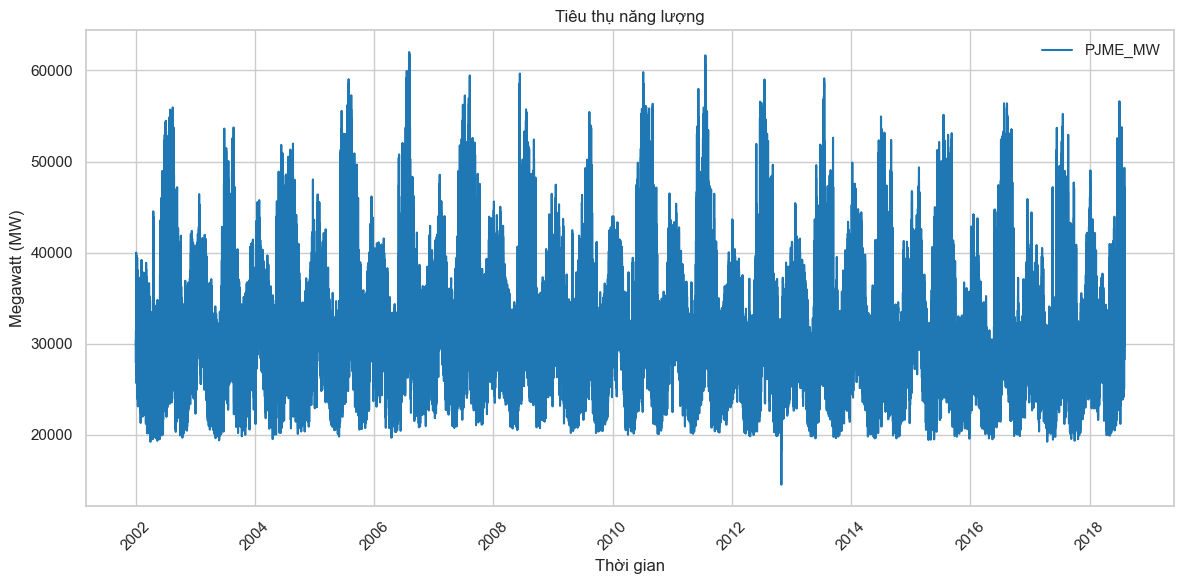

In [81]:
acf_color = '#1f77b4'   
zero_line_color = '#d62728'  
plt.figure(figsize=(12, 6))
plt.plot(df_PJME_ts.index, df_PJME_ts['PJME_MW'], label='PJME_MW', color=acf_color)
plt.title('Tiêu thụ năng lượng')
plt.xlabel('Thời gian')
plt.ylabel('Megawatt (MW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Kiểm tra tính dừng 

Chuỗi dừng là chuỗi thời gian có các đặc tính thống kê như kỳ vọng, phương sai và tự tương quan không thay đổi theo thời gian.

Khác với các mô hình thống kê truyền thống như ARIMA, XGBoost không yêu cầu chuỗi thời gian phải dừng. Tuy nhiên, việc hiểu và kiểm tra tính dừng của chuỗi vẫn rất quan trọng. Điều này giúp nhận diện các yếu tố như xu hướng (trend) và mùa vụ (seasonality) trong dữ liệu.

Dựa trên những hiểu biết này, ta có thể tạo ra các đặc trưng bổ sung như Year, Month, Day, Season, và Lag, từ đó giúp XGBoost học và hiểu cấu trúc thời gian của dữ liệu tốt hơn.

In [82]:
adf_result = adfuller(df_PJME_ts.iloc[:, 0])
test_statistic, p_value, _, _, _, _ = adf_result

print(f'ADF Statistic: {test_statistic}')
print(f'P-value: {p_value}')

if p_value <= 0.05:
	print('Reject the null hypothesis: The time series is Stationary.')
else:
	print('Fail to reject the null hypothesis: The time series is Non-Stationary.')

ADF Statistic: -19.964593931840735
P-value: 0.0
Reject the null hypothesis: The time series is Stationary.


In [83]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Kiểm tra tính tự tương quan
Biểu đồ tương quan 7 ngày:
- Biểu đồ trên cho thấy mẫu lặp lại rõ ràng cứ mỗi 24 giờ, xác nhận dữ liệu tiêu thụ năng lượng có chu kỳ hàng ngày 
- Thể hiện tương quan mạnh giữa tiêu thụ năng lượng tại một giờ nhất định với cùng giờ đó vào ngày hôm sau

Biểu đồ tương quan 5 năm:
- Chu kỳ mùa vụ rõ ràng, với các đỉnh và đáy lặp lại theo thời gian
- Biên độ của các đỉnh giảm dần theo thời gian, cho thấy mối tương quan yếu dần khi khoảng cách thời gian tăng lên.

(-0.6, 1.2)

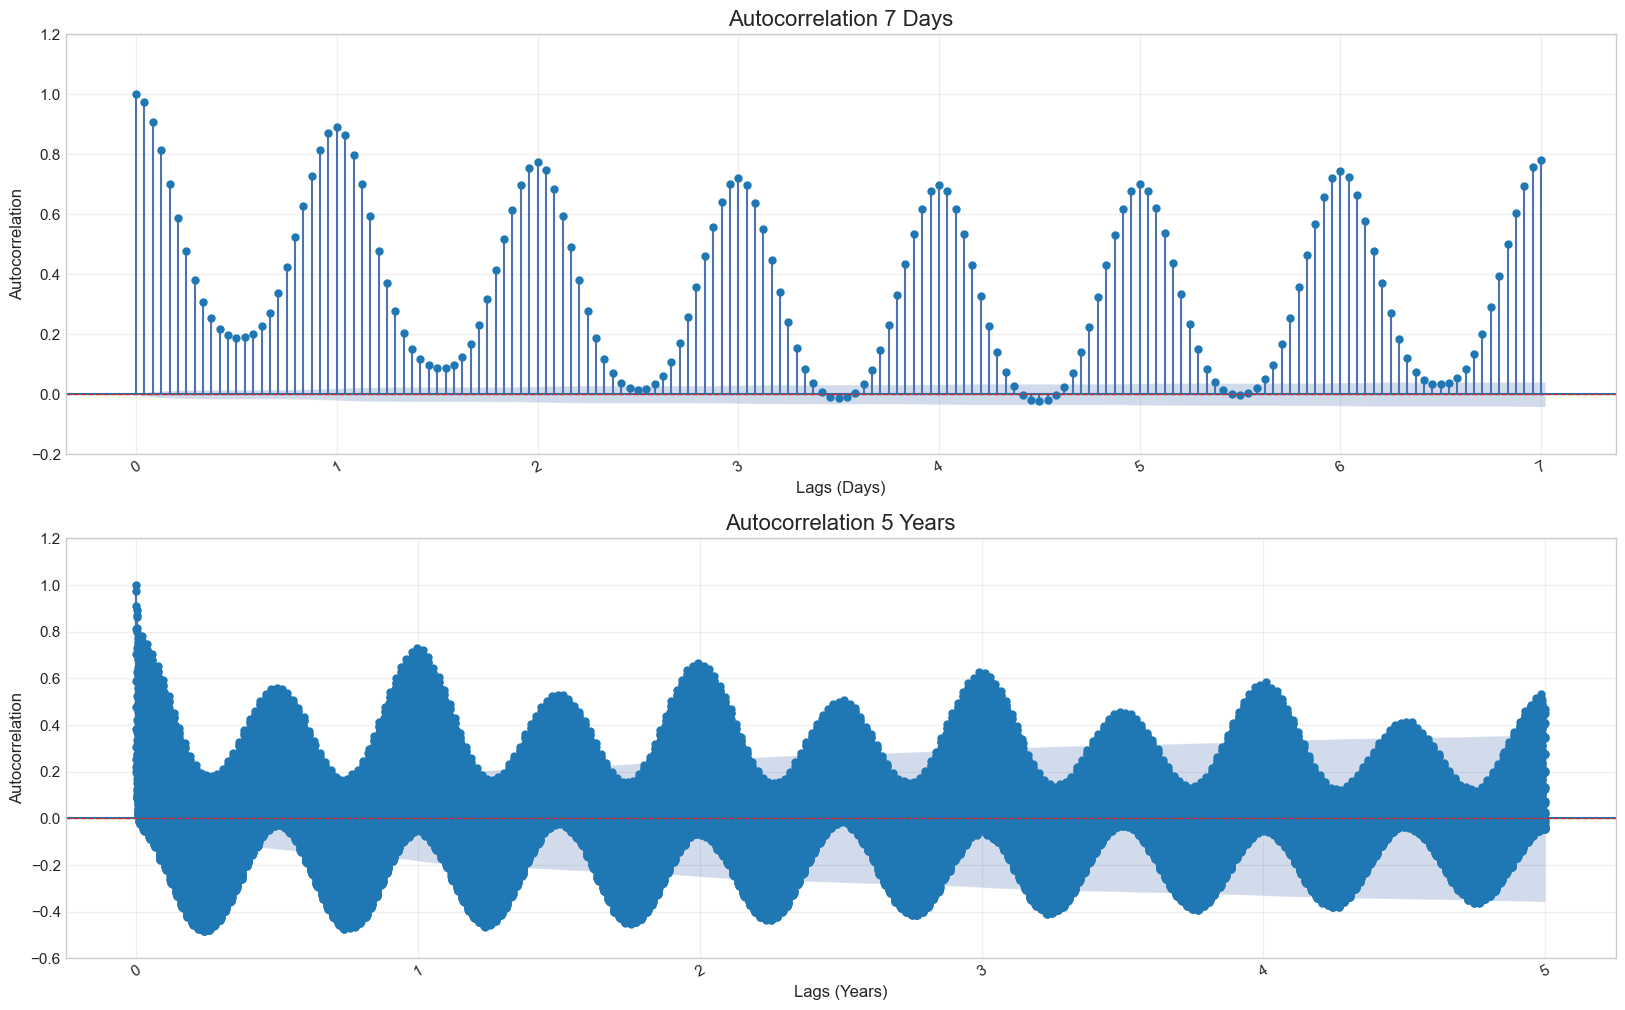

In [84]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))


# Biểu đồ ACF 7 ngày
plot_acf(df_PJME_ts['PJME_MW'], lags=24*7, ax=ax[0], color=acf_color)
ax[0].set_title('Autocorrelation 7 Days', fontsize=16)
ax[0].set_xlabel('Lags (Days)', fontsize=12)
ax[0].set_ylabel('Autocorrelation', fontsize=12)
ax[0].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)
ax[0].grid(alpha=0.3)

hours_featured = [i for i in range(0, 7*24+1, 24)]
ax[0].set_xticks(hours_featured)
days_featured = [f"{hour / 24:.0f}" for hour in hours_featured]
ax[0].set_xticklabels(days_featured, rotation=30)
ax[0].grid(alpha=0.3)


# Biểu đồ ACF 5 năm
plot_acf(df_PJME_ts['PJME_MW'], lags=24*365*5, ax=ax[1], color=acf_color)
ax[1].set_title('Autocorrelation 5 Years', fontsize=16)
ax[1].set_xlabel('Lags (Years)', fontsize=12)
ax[1].set_ylabel('Autocorrelation', fontsize=12)
ax[1].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)

hours_featured = [i for i in range(0, 5*365*24+1, 365*24)]
ax[1].set_xticks(hours_featured)
days_featured = [f"{hour / (365*24):.0f}" for hour in hours_featured]
ax[1].set_xticklabels(days_featured, rotation=30)
ax[1].grid(alpha=0.3)

ax[0].set_ylim(-0.2, 1.2)
ax[1].set_ylim(-0.6, 1.2)

### Tiêu thụ năng lượng trung bình theo giờ trong ngày
Xác định xu hướng tiêu thụ điện theo giờ
Tiêu thụ thấp nhất vào khoảng 3-5 giờ sáng, tăng dần trong ngày và đạt đỉnh vào buổi tối (18-19 giờ)

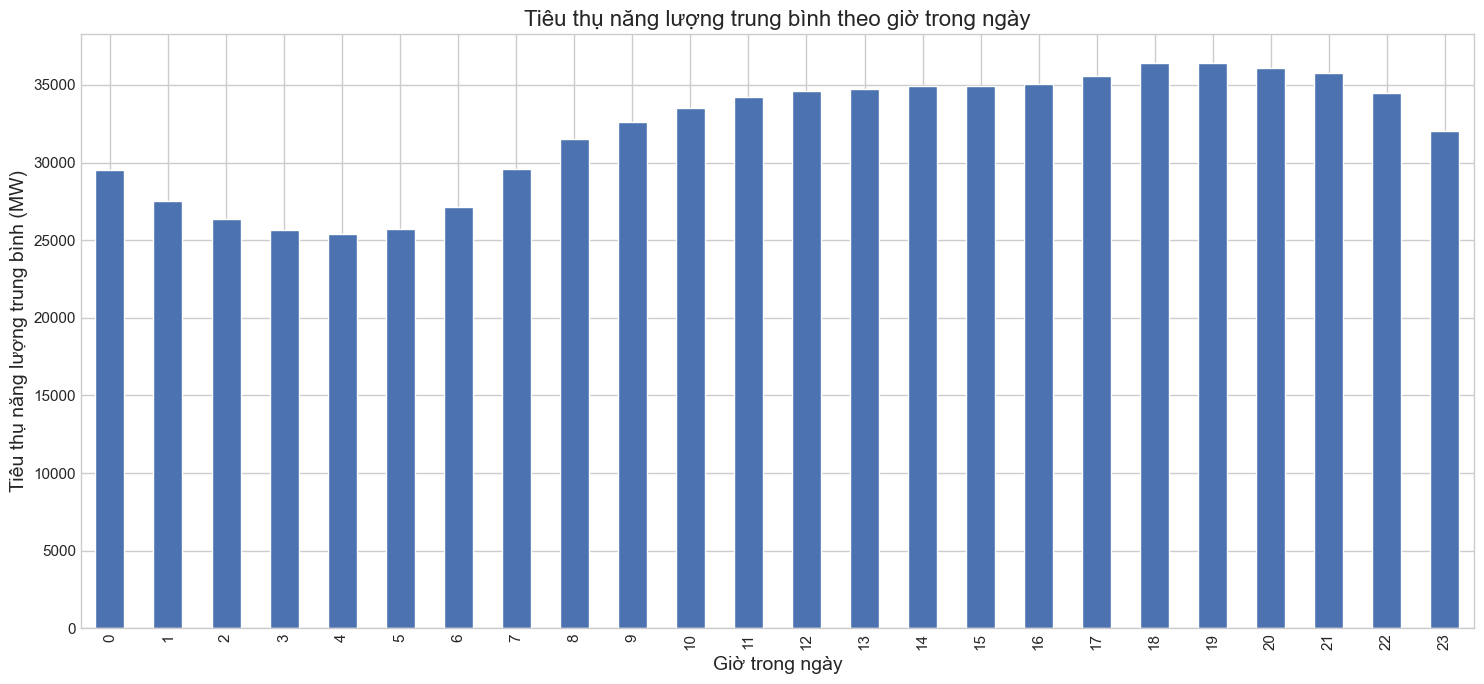

In [85]:
plt.figure(figsize=(15, 7))
hourly_avg = df_PJME_ts.groupby('Hour')['PJME_MW'].mean()
hourly_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo giờ trong ngày', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Giờ trong ngày', fontsize=14)
plt.tight_layout()

### Năng lượng tiêu thụ trung bình của từng ngày trong tuần 

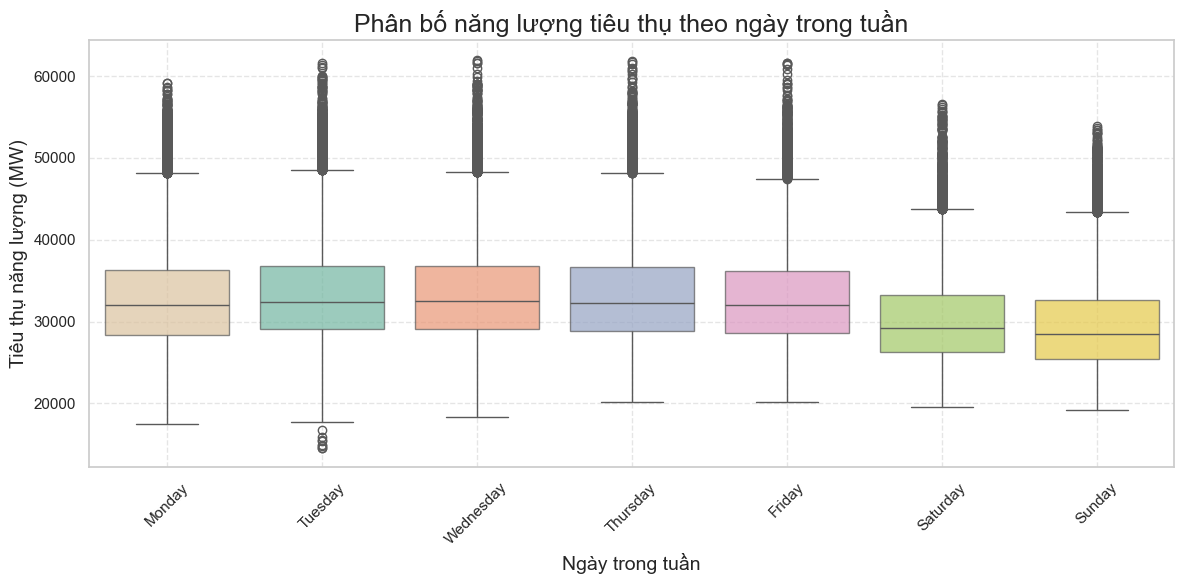

In [86]:
# Ánh xạ tên thứ
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Thêm cột 'dayofweek' và 'day_name' vào DataFrame
df_PJME_ts['dayofweek'] = df_PJME_ts.index.dayofweek
df_PJME_ts['day_name'] = df_PJME_ts['dayofweek'].map(day_names)

# Sắp xếp theo đúng thứ tự trong tuần
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Cài đặt giao diện đẹp
sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))

# Boxplot hiển thị min, max, trung vị, IQR
sns.boxplot(
    x='day_name',
    y='PJME_MW',
    hue='day_name',
    data=df_PJME_ts,
    order=order,
    palette='Set2',
    boxprops=dict(alpha=0.7)
)

plt.title('Phân bố năng lượng tiêu thụ theo ngày trong tuần', fontsize=18)
plt.xlabel('Ngày trong tuần', fontsize=14)
plt.ylabel('Tiêu thụ năng lượng (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Tiêu thụ năng lượng trung bình theo mùa
Mùa Hạ có tiêu thụ điện cao nhất, theo sau là mùa Đông

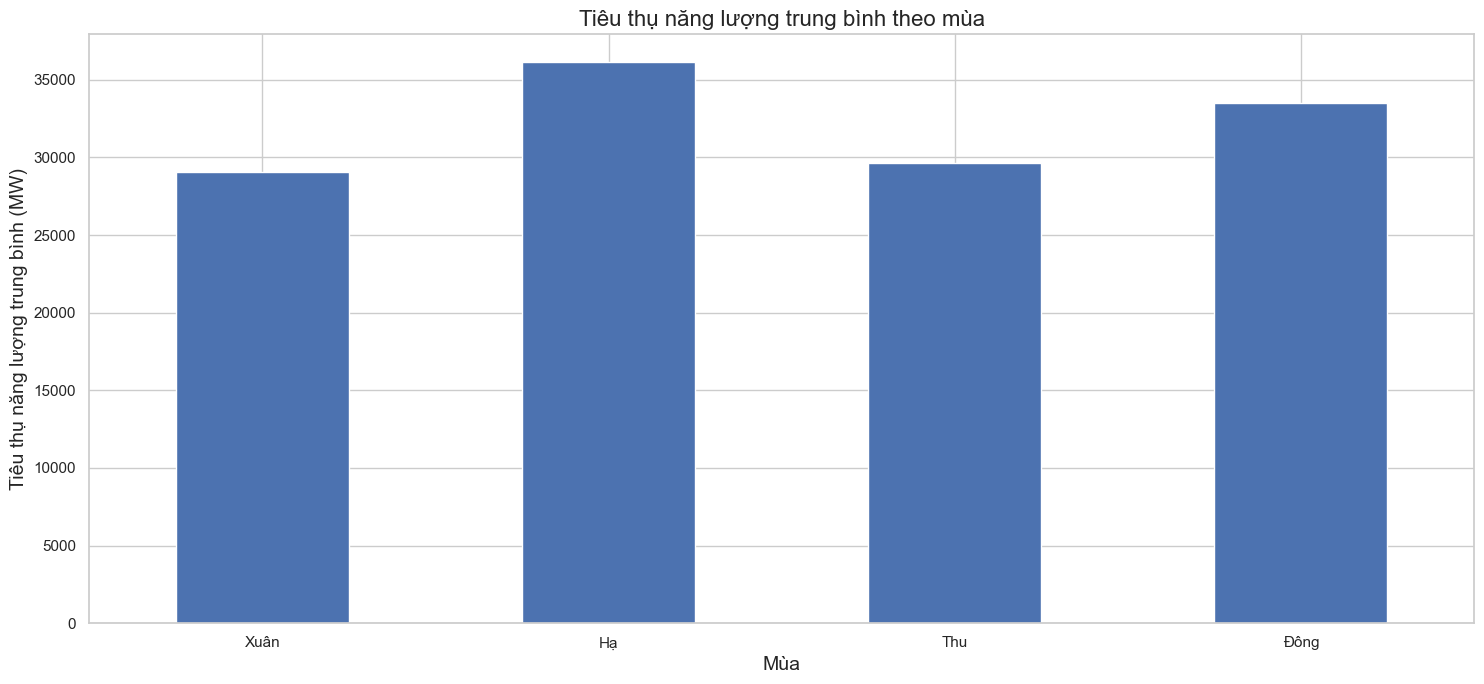

In [87]:
plt.figure(figsize=(15, 7))
season_names = ['Xuân', 'Hạ', 'Thu', 'Đông']
season_avg = df_PJME_ts.groupby('Season')['PJME_MW'].mean()
season_avg.index = season_names
season_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo mùa', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Mùa', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()

---
# 5. Tạo pipe tiền xử lí

### Feature engineering
Dựa trên biểu đồ tương quan theo độ trễ, tôi nhận thấy mẫu tiêu thụ năng lượng lặp lại rõ ràng theo chu kỳ 24 giờ – tức là có tính chu kỳ hàng ngày. Ngoài ra, giá trị tiêu thụ năng lượng tại một thời điểm cụ thể có tương quan mạnh với chính thời điểm đó vào ngày hôm sau.

In [89]:
def feature_engineering(df):
    df = df.copy()

    # Rolling statistics (shift bằng window để căn chỉnh ngày/tuần)
    for window in [24, 24*7]:
        df[f'rolling_mean_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).mean()      # window=24 thì rolling[-24, -1]
        df[f'rolling_std_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).max()

        df[f'rolling_mean_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).mean()      # window=24 thì rolling[-48, -24]
        df[f'rolling_std_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).std()
        df[f'rolling_min_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).min()
        df[f'rolling_max_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).max()


    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(1, 24), (24, 6), (24*7, 5), (24*365, 4)]:
        df[f'base_{diff}h'] = df.iloc[:, 0].shift(diff)
        diff_value = df.iloc[:,0].diff(diff)
        for i in range(1, lag+1) :
            df[f'diff_{diff}h_lag_{i*diff}h'] = diff_value.shift(diff * i)
            

    # Drop rows with any NaN values
    # Lưu ý đoạn trên, nếu diff * lag quá lớn thì drop gần hết bảng
    df.dropna(inplace=True)

    return df

In [92]:
preprocessing_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows)),
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

Sau khi xây dựng pipeline tiền xử lý gồm các bước tạo đặc trưng và xử lý giá trị khuyết (NaN), tôi áp dụng pipeline này cho toàn bộ dữ liệu gốc:

In [93]:
df_copy = PJME_df_origin.copy()
df_copy['Datetime'] = pd.to_datetime(df_copy['Datetime'])
df_copy.set_index('Datetime', inplace=True)

processed_df = preprocessing_pipeline.fit_transform(df_copy)
processed_df.info()

C:\Users\Blade\AppData\Local\Temp\ipykernel_13572\3278493436.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101592 entries, 2006-12-31 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 69 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   PJME_MW                     101592 non-null  float64
 1   Year                        101592 non-null  int32  
 2   Quarter                     101592 non-null  int32  
 3   Month                       101592 non-null  int32  
 4   Day                         101592 non-null  int32  
 5   Hour                        101592 non-null  int32  
 6   Day_of_Year                 101592 non-null  int32  
 7   Weekday                     101592 non-null  int32  
 8   Is_Weekend                  101592 non-null  int8   
 9   Season                      101592 non-null  int64  
 10  rolling_mean_24h            101592 non-null  float64
 11  rolling_std_24h             101592 non-null  float64
 12  rolling_min_24h             10

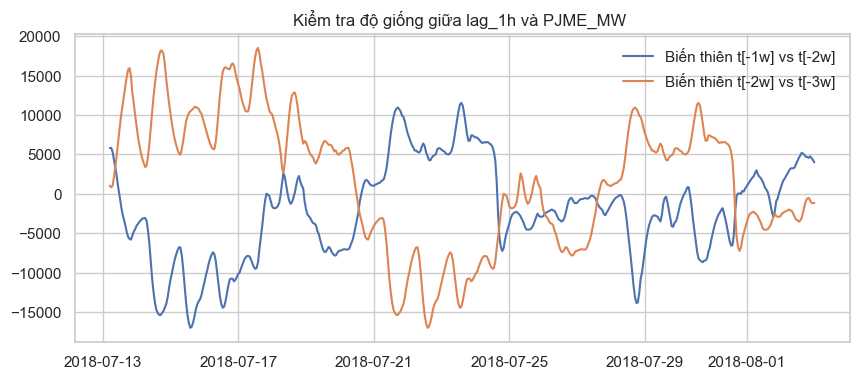

In [96]:
plt.figure(figsize=(10,4))

# plt.plot(processed_df['diff_1h_lag_1h'].iloc[-500:], label='t[-1h] vs t[-2h]')
# plt.plot(processed_df['diff_1h_lag_2h'].iloc[-500:], label='t[-2h] vs t[-3h]')

# plt.plot(processed_df['diff_24h_lag_24h'].iloc[-500:], label='Biến thiên t[-1d] vs t[-2d]')
# plt.plot(processed_df['diff_24h_lag_48h'].iloc[-500:], label='Biến thiên t[-2d] vs t[-3d]')

plt.plot(processed_df['diff_168h_lag_168h'].iloc[-500:], label='Biến thiên t[-1w] vs t[-2w]')
plt.plot(processed_df['diff_168h_lag_336h'].iloc[-500:], label='Biến thiên t[-2w] vs t[-3w]')

# plt.plot(processed_df['diff_8760h_lag_8760h'].iloc[-500:], label='Biến thiên t[-1y] vs t[-2y]')
# plt.plot(processed_df['diff_8760h_lag_17520h'].iloc[-500:], label='Biến thiên t[-2y] vs t[-3y]')
# plt.plot(processed_df['diff_8760h_lag_26280h'].iloc[-500:], label='Biến thiên t[-2y] vs t[-3y]')

plt.legend()
plt.title('Kiểm tra độ giống giữa lag_1h và PJME_MW ')
plt.show()


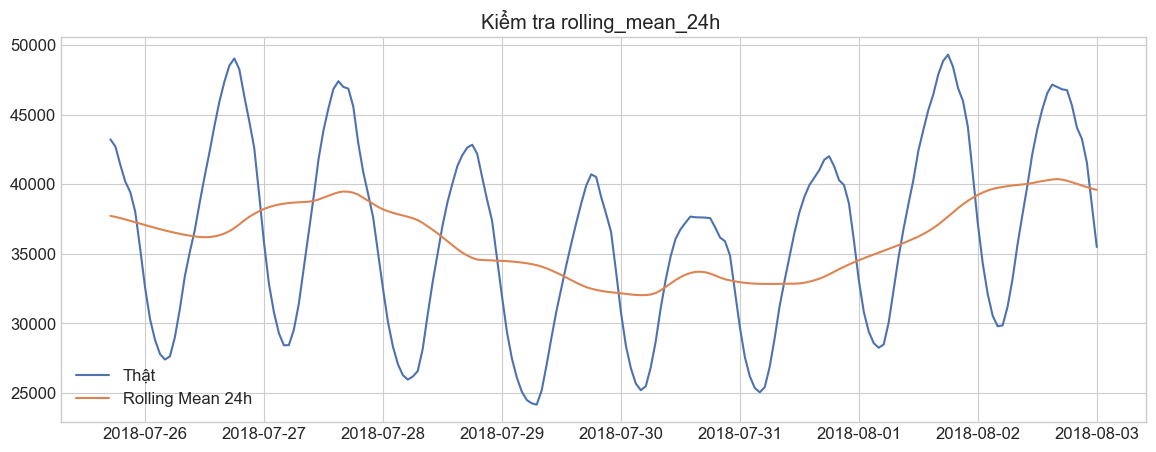

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(processed_df.iloc[-200:, 0], label='Thật')
plt.plot(processed_df['rolling_mean_24h'].iloc[-200:], label='Rolling Mean 24h')
plt.legend()
plt.title("Kiểm tra rolling_mean_24h ")
plt.show()


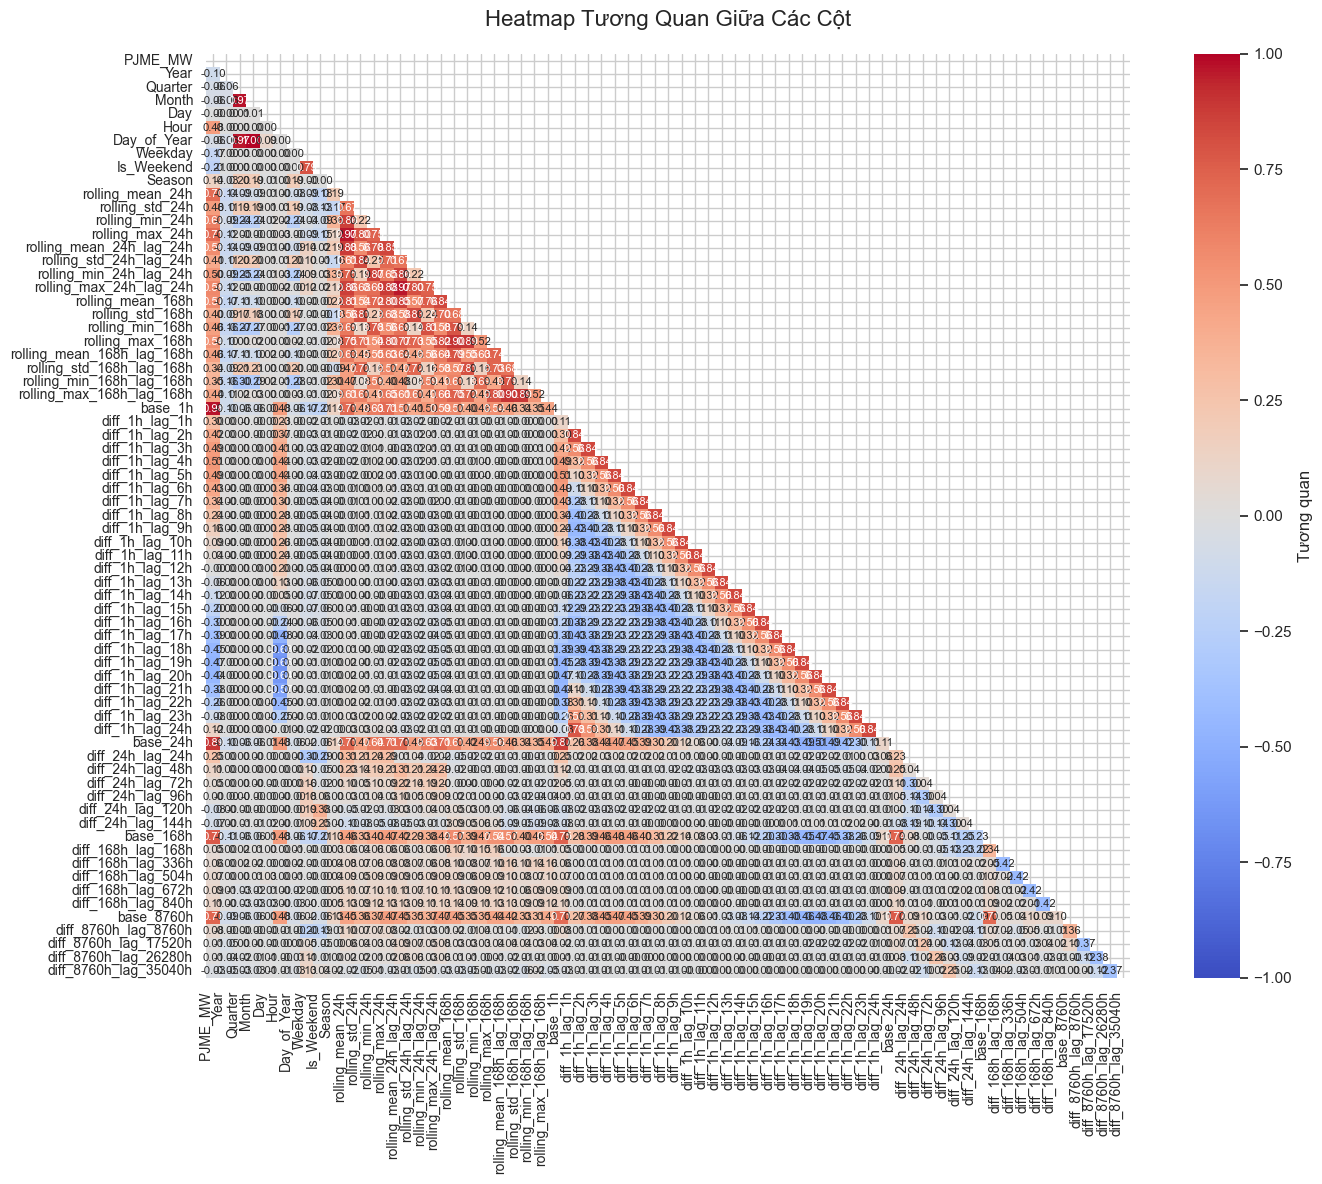

In [ ]:
# Tính ma trận tương quan cho processed_df
correlation = processed_df.corr()

# Tạo mask để chỉ hiển thị nửa dưới của ma trận (loại bỏ nửa trên đối xứng)
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Thiết lập kích thước hình (tăng kích thước để phù hợp với 25 cột)
plt.figure(figsize=(15, 12))

# Vẽ heatmap
sns.heatmap(correlation, 
            annot=True,            # Hiển thị giá trị tương quan
            fmt='.2f',             # Định dạng số thập phân (2 chữ số)
            cmap='coolwarm',       # Màu sắc: xanh lam -> đỏ
            mask=mask,             # Áp dụng mask để ẩn nửa trên
            vmin=-1, vmax=1,       # Giới hạn thang màu từ -1 đến 1
            square=True,           # Tỷ lệ ô vuông
            cbar_kws={'label': 'Tương quan'},  # Nhãn cho thanh màu
            annot_kws={'size': 8}, # Cỡ chữ cho giá trị tương quan
            xticklabels=correlation.columns,  # Nhãn trục x
            yticklabels=correlation.columns)  # Nhãn trục y

# Xoay nhãn trục x để dễ đọc
plt.xticks(rotation=-90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Đặt tiêu đề với cỡ chữ phù hợp
plt.title('Heatmap Tương Quan Giữa Các Cột', fontsize=16, pad=20)

# Điều chỉnh layout để không bị cắt
plt.tight_layout()

plt.show()

# # Lưu hình ảnh
# plt.savefig('adjusted_correlation_heatmap.png')

# # Đóng plot để tránh hiển thị dư thừa
# plt.close()

In [101]:
def select_features_by_correlation(corr_matrix, target_col='PJME_MW', threshold=0.8):
    # 1. Lấy tất cả các feature (không lọc theo tương quan với target)
    all_features = [col for col in corr_matrix.columns if col != target_col]
    
    # 2. Lấy tương quan của các feature với target để so sánh
    target_corr = corr_matrix[target_col].drop(target_col)
    
    # 3. Duyệt các cặp feature và loại bỏ nếu tương quan lớn hơn threshold (đa cộng tuyến)
    to_remove = set()
    # for i in range(len(all_features)):
    #     for j in range(i + 1, len(all_features)):
    #         f1, f2 = all_features[i], all_features[j]
    #         # Nếu abs(tương quan của f1, f2) > threshold
    #         if abs(corr_matrix.loc[f1, f2]) > threshold:
    #             # Nếu abs(tương quan của f1 với target) lớn hơn thì bỏ f2
    #             if abs(target_corr[f1]) > abs(target_corr[f2]):
    #                 to_remove.add(f2)
    #             else:
    #                 to_remove.add(f1)
    
    # 4. Loại bỏ các feature trong to_remove
    final_features = [f for f in all_features if f not in to_remove]
    
    return final_features

In [102]:
correlation = processed_df.corr()
feature_columns = select_features_by_correlation(correlation, target_col=processed_df.columns[0])
feature_columns

['Year',
 'Quarter',
 'Month',
 'Day',
 'Hour',
 'Day_of_Year',
 'Weekday',
 'Is_Weekend',
 'Season',
 'rolling_mean_24h',
 'rolling_std_24h',
 'rolling_min_24h',
 'rolling_max_24h',
 'rolling_mean_24h_lag_24h',
 'rolling_std_24h_lag_24h',
 'rolling_min_24h_lag_24h',
 'rolling_max_24h_lag_24h',
 'rolling_mean_168h',
 'rolling_std_168h',
 'rolling_min_168h',
 'rolling_max_168h',
 'rolling_mean_168h_lag_168h',
 'rolling_std_168h_lag_168h',
 'rolling_min_168h_lag_168h',
 'rolling_max_168h_lag_168h',
 'base_1h',
 'diff_1h_lag_1h',
 'diff_1h_lag_2h',
 'diff_1h_lag_3h',
 'diff_1h_lag_4h',
 'diff_1h_lag_5h',
 'diff_1h_lag_6h',
 'diff_1h_lag_7h',
 'diff_1h_lag_8h',
 'diff_1h_lag_9h',
 'diff_1h_lag_10h',
 'diff_1h_lag_11h',
 'diff_1h_lag_12h',
 'diff_1h_lag_13h',
 'diff_1h_lag_14h',
 'diff_1h_lag_15h',
 'diff_1h_lag_16h',
 'diff_1h_lag_17h',
 'diff_1h_lag_18h',
 'diff_1h_lag_19h',
 'diff_1h_lag_20h',
 'diff_1h_lag_21h',
 'diff_1h_lag_22h',
 'diff_1h_lag_23h',
 'diff_1h_lag_24h',
 'base_24h',
 '

### Chia tập dữ liệu train/ test
85% train, 15% test

---
# 6. Xây dựng mô hình

## 6.1. Phương pháp dự đoán:
<ol>
    <li>Phân tách dữ liệu:<br> Ta tiến hành tách dữ liệu theo dòng thơi gian, với 80% dùng cho huấn luyện mô hình, và 20% cho đối chiếu. Trong trường hợp với bộ dữ liệu ít hơn, ta cũng xét tới việc tách 1 năm cuối cùng để đối chiếu, thay vì chia tỉ lệ</li>
    <li>Huấn luyện mô hình XGBoost:<br> Dựa trên tập huẩn luyện (training_data), ta tạo các đặc trưng có ý nghĩa như đã thực hiện lọc ở phần trên, và đưa các mẫu để huấn luyện mô hình. Việc lựa chọn các tham số để cải thiến tiến trình, kết quả và mức ăn khớp của mô hình trên các 2 tập dữ liệu sẽ được đề cập sau.</li>
    <li>Thực hiện dự đoán:<br> Ta bắt đầu với training_data như một dữ liệu bối cảnh (context). Thực hiện tạo sinh các đặc trưng cho thời điểm tiếp theo trong dòng thời gian và cho mô hình dự đoán. Kết quả dự đoán sẽ được nối vào với bối cảnh phục vụ cho việc dự đoán thời điểm tiếp theo.<br> Sơ bộ, ta đánh giá được luôn rằng độ chính xác về mặt số liệu sẽ giảm dần theo thời gian, tuy nhiên, mục tiêu chúng tôi đánh giá cao và muốn hướng tới thiên về dự đoán được xu hướng.</li>
</ol>


In [103]:
# Chia tập huấn luyện
dataset = PJME_df_origin.copy()

dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
dataset.set_index('Datetime', inplace=True)
dataset.sort_index(inplace=True)

train_size = int(0.85 * len(dataset))
train_data = dataset.iloc[:train_size].copy()
test_data = dataset.iloc[train_size:].copy()
train_data

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2016-02-06 06:00:00,29972.0
2016-02-06 07:00:00,31468.0
2016-02-06 08:00:00,32668.0


In [104]:
# Tạo đặc trưng cho huấn luyện
preprocessing_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows)),
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

train_data = preprocessing_pipeline.fit_transform(train_data)

correlation = processed_df.corr()
feature_columns = select_features_by_correlation(correlation)

X_train = train_data[feature_columns]   # Input
y_train = train_data.iloc[:, 0]         # Output


C:\Users\Blade\AppData\Local\Temp\ipykernel_13572\3278493436.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


In [105]:
# Điều chỉnh tập test
fixing_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows))
])

test_data = fixing_pipeline.fit_transform(test_data)

# Input test sẽ được khởi tạo sau
y_test = test_data.iloc[:, 0]

C:\Users\Blade\AppData\Local\Temp\ipykernel_13572\3278493436.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


In [ ]:
# Tạo features và tiến hành dự đoán AutoRRegressive cho từng dòng trong testing set

def create_next_row_features (context) :
    """
    Trả về một dict chứa thông tin các features có thể cần cho index Datetime tiếp theo của context.
    Điều kiện context phải sort rồi. (lúc chia đã sort)
    Sửa code thì phải theo cái create_feature trên pipeline tạo đặc trưng nha.
    """
    next_row = {}
    for window in [24, 24*7] :
        next_row[f'rolling_mean_{window}h'] = context.iloc[-window:, 0].mean()
        next_row[f'rolling_std_{window}h'] = context.iloc[-window:, 0].std()
        next_row[f'rolling_min_{window}h'] = context.iloc[-window:, 0].min()
        next_row[f'rolling_max_{window}h'] = context.iloc[-window:, 0].max()

        next_row[f'rolling_mean_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].mean()
        next_row[f'rolling_std_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].std()
        next_row[f'rolling_min_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].min()
        next_row[f'rolling_max_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].max()

    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(1, 24), (24, 6), (24*7, 5), (24*365, 4)]:
        next_row[f'base_{diff}h'] = context.iloc[-diff, 0]
        next_row[f'diff_{diff}h_lag_{diff}h'] = context.iloc[-diff, 0] - context.iloc[-diff*2, 0]
        for i in range(2, lag+1) :
            next_row[f'diff_{diff}h_lag_{i*diff}h'] = context.iloc[-diff,][f'diff_{diff}h_lag_{(i-1)*diff}h'] 

    return next_row

def create_datetime_features(time:pd.DatetimeIndex) :
    time_features = {}
    time_features['Year'] = time.year
    time_features['Quarter'] = time.quarter
    time_features['Month'] = time.month
    time_features['Day'] = time.day
    time_features['Hour'] = time.hour

    time_features['Day_of_Year'] = time.dayofyear

    time_features['Weekday'] = time.weekday()
    time_features['Is_Weekend'] = 1 if time_features['Weekday'] in [5, 6] else 0  # Kiểm tra cuối tuần

    # Xác định mùa trong năm
    if 3 <= time_features['Month'] <= 5:
        time_features['Season'] = 1  # Xuân
    elif 6 <= time_features['Month'] <= 8:
        time_features['Season'] = 2  # Hạ
    elif 9 <= time_features['Month'] <= 11:
        time_features['Season'] = 3  # Thu
    else:
        time_features['Season'] = 4  # Đông
    
    return time_features

def predict(model, context, end_predict) :
    one_hour = pd.Timedelta('1h')
    last_context_index = context.index[-1]
    current_time = last_context_index + one_hour 

    MW = context.columns[0]
    while current_time <= end_predict:
        new_row = {MW : np.nan} | create_datetime_features(current_time) | create_next_row_features(context)
        new_row = pd.DataFrame(new_row, index=[current_time])[[MW] + feature_columns]
        new_row.loc[current_time, MW] = model.predict(new_row[feature_columns])[0]

        frame = min([8760*2+10, len(context)])
        context = pd.concat([context.tail(frame), new_row])           ## Để giảm tải thời gian copy
        current_time += one_hour

    last_context_loc = context.index.get_loc(last_context_index)
    return context.iloc[last_context_loc + 1:, 0].copy()



In [108]:
# Xây dựng model và cung cấp model đó cho hàm predict

# Khởi tạo mô hình với các siêu tham số đã tìm được
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(X_train, y_train)

y_predict = predict(model=xgb_model,
                    context=train_data,
                    end_predict=y_test.index[min([len(y_test), 5*30*24])])

# 3ph20 chạy đủ 1 năm nha fenz. Tại tập test dài, nó cứ copy lại mỗi vòng lặp nên đốt RAM :v

## 6.2. Phương pháp đánh giá mô hình:
<ul>
    <li>Trực tiếp: ta sử dụng đồ thị và so sánh độ sai lệch, tính xu hướng của kết quả dự đoán</li>
    <li>Đánh giá dựa trên thông số
        <ul>
            <li>MAE - Mean Absolute Error: trung bình sai phân tuyệt đối</li>
            <li>MAPE - Mean Absolute Percentage Error: trung bình tỉ lệ sai phân tuyệt đối</li> 
            <li>MSE - Mean Square Error: trung bình phương sai</li>
            <li>MSPE - r^2 score: trung bình tỉ lệ phương sai</li>
            <li>Correlation Coefficient (Pearson’s r): Hệ số tương quan, thông số này tập trung phản ánh xu hướng (trend) tốt hơn, nhưng bỏ qua độ lệch điểm.</li>
        </ul>
    </li>
</ul>

In [109]:
# Vẽ đồ thị so sánh
def plot_compare(y_test, y_predict) :
    plt.figure(figsize=(15, 5))

    # Vẽ hai đường
    plt.plot(y_test.index, y_test, label='Kết quả thực', color='blue', linewidth=2)
    plt.plot(y_predict.index, y_predict, label='Dự đoán', color='orange', linewidth=2)
    

    # Thêm tiêu đề và nhãn
    plt.title('So sánh kết quả thực có và dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Mức tiêu thụ (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [110]:
from scipy.stats import pearsonr

def score_compare (y_test, y_predict) :
    mae = mean_absolute_error(y_test, y_predict)
    mape = np.mean(np.abs((y_test - y_predict) / y_test)) * 100
    mse = mean_squared_error(y_test, y_predict)

    pearson, _ = pearsonr(y_test, y_predict)
    
    print(f'MAE : {mae:.2f} (~0 nghĩa là tốt hơn)')
    print(f'MAPE: {mape:.2f}% (~0 nghĩa là tốt hơn)')
    print(f'MSE : {mse:.2f} (~0 nghĩa là tốt hơn)')
    print(f'Pearson\'s r {pearson:.2f} (~1 nghĩa là phản ánh được xu hướng)')

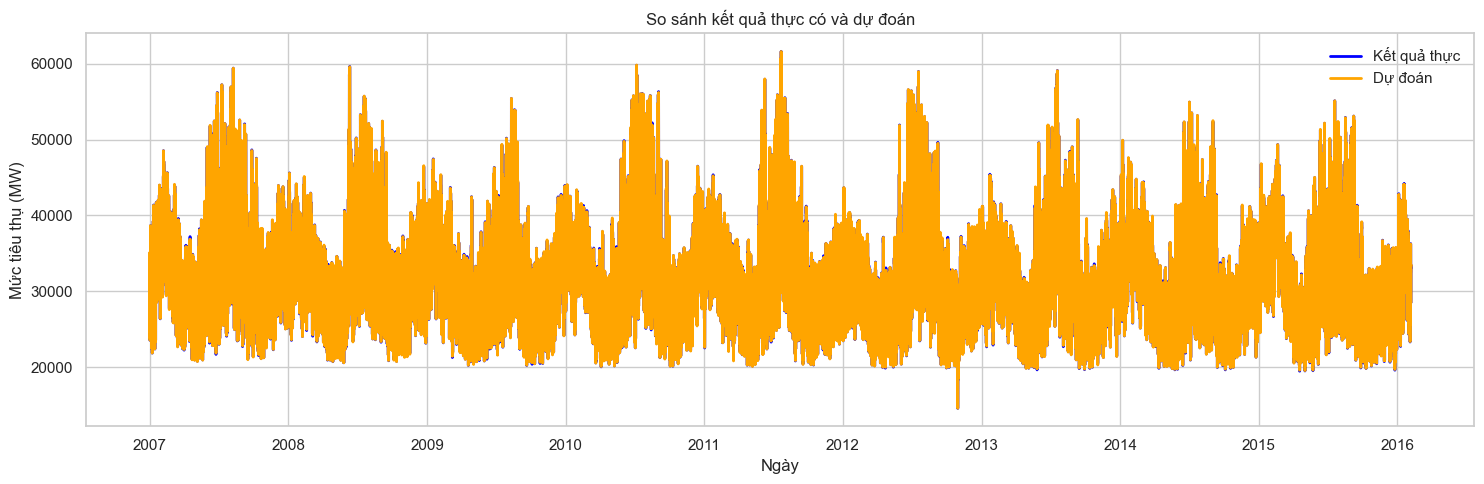

MAE : 74.79 (~0 nghĩa là tốt hơn)
MAPE: 0.24% (~0 nghĩa là tốt hơn)
MSE : 9424.94 (~0 nghĩa là tốt hơn)
Pearson's r 1.00 (~1 nghĩa là phản ánh được xu hướng)


In [111]:
train_repredict = pd.Series(xgb_model.predict(X_train), index=X_train.index)

plot_compare(y_train, train_repredict)
score_compare(y_train, train_repredict)

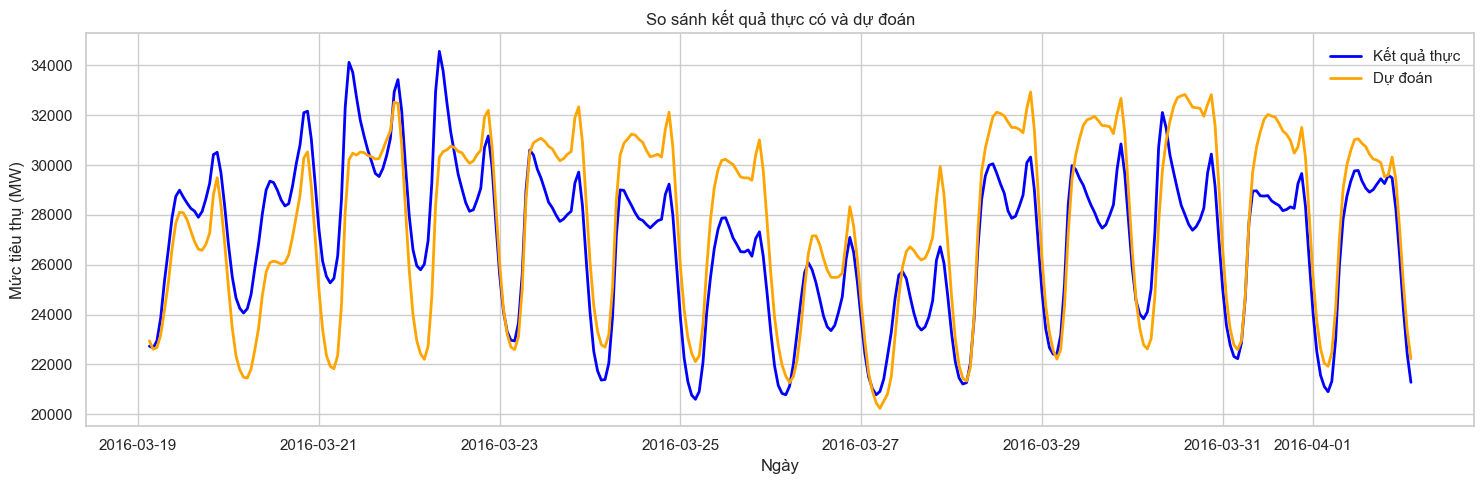

MAE : 1874.64 (~0 nghĩa là tốt hơn)
MAPE: 6.90% (~0 nghĩa là tốt hơn)
MSE : 4792430.92 (~0 nghĩa là tốt hơn)
Pearson's r 0.81 (~1 nghĩa là phản ánh được xu hướng)


In [112]:
test_predict = pd.Series(y_predict, index=y_predict.index) # đã dự đoán ở 6.1

zoom = (0.6, 0.9)       # Khu vực zoom in của biểu đồ (theo %)

draw_len = test_predict.size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])
start = 1000
end = 1000 + 24*7 * 2
plot_compare(y_test[start:end], test_predict[start:end])
score_compare(y_test[start:end], test_predict[start:end])

# 7. Đánh giá quy trình xử lý:
Bởi ta đang thực hiện dự đoán với PJME_hourly.csv, bộ dữ liệu gần như đầy đủ nhất hiện có, việc quy trình xử lý trên đã đảm bảo yêu cầu hay chưa vẫn không hoàn toàn đảm bảo, vì thế, toàn bộ tiến trình trên sẽ phải thực hiện trên một số tập dữ liệu khác nữa để có được đánh giá tổng quan nhất

In [113]:
# Cũ, cần xem lại, hình như nó không hợp

scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R²: {np.mean(scores):.4f}")

Cross-validated R² scores: [0.99861559 0.99871249 0.99857746 0.99816379 0.99865675]
Mean R²: 0.9985
